<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta

from keras.utils.vis_utils import plot_model
from IPython.display import Image 
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

# install optuna
! pip install optuna

import optuna


batch_size = 128
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)

     |████████████████████████████████| 296kB 5.6MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 1.1MB 12.7MB/s 
     |████████████████████████████████| 112kB 32.5MB/s 
     |████████████████████████████████| 143kB 18.6MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 481kB 19.9MB/s 
  Created wheel for alembic: filename=alembic-1.5.3-py2.py3-none-any.whl size=155547 sha256=f1c2e0b1c25f962c9141e17ac93e40b261cfcea295b25ccefa740c823d1585ee
  Stored in directory: /root/.cache/pip/wheels/7f/ed/1b/a66a0cbca75fd3e374bd5cc60c443e5675f10ef1f1f78ec31d
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=a9fea8964172c290d7baaeba065de55dbca8efded5141dfe0b603fe24259a819
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha

In [ ]:
N_TRAIN_EXAMPLES = 1500 #3000
N_TEST_EXAMPLES = 12000
x_train = x_train[:N_TRAIN_EXAMPLES]
x_test = x_test[:N_TEST_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]
y_test = y_test[:N_TEST_EXAMPLES]

In [ ]:
def c_model():
  # Our old fully connected (dense) network
  #model = Sequential()
  #model.add(Dense(512, activation='relu', input_shape=(784,)))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(num_classes, activation='softmax'))
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [ ]:
def objective(trial):
  
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  zoom_range=trial.suggest_uniform('zoom_range', .00,0.30)
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  
  datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

  model = c_model()

  from keras.callbacks import EarlyStopping

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  
  e_s=EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)

  history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    validation_data=(x_test, y_test), 
                    callbacks=[e_s])

  score = model.evaluate(x_test, y_test,verbose=0)

  return score[1]

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=30, timeout=1200)

[I 2021-02-03 01:10:35,315] A new study created in memory with name: no-name-46369b4b-9858-4792-9580-ba8ea99570e7
[I 2021-02-03 01:20:30,683] Trial 0 finished with value: 0.9789999723434448 and parameters: {'rotation_range': 10.515318814244985, 'zoom_range': 0.2979079538943456, 'shift_range': 0.14691656703037756}. Best is trial 0 with value: 0.9789999723434448.
[I 2021-02-03 01:30:18,702] Trial 1 finished with value: 0.9758999943733215 and parameters: {'rotation_range': 16.87098545259085, 'zoom_range': 0.1742852060493267, 'shift_range': 0.16828404716679665}. Best is trial 0 with value: 0.9789999723434448.
[I 2021-02-03 01:40:06,040] Trial 2 finished with value: 0.9814000129699707 and parameters: {'rotation_range': 16.069385416599015, 'zoom_range': 0.17165833661138702, 'shift_range': 0.030133525022610776}. Best is trial 2 with value: 0.9814000129699707.


In [ ]:
print("Number trials: {}".format(len(study.trials)))
print("Best trial:")
trial=study.best_trial
print("Value: {}".format(trial.value))
print("Params")
for key, value in trial.params.items():
  print("  {}:{}  ".format(key, value))

Number trials: 3
Best trial:
Value: 0.9814000129699707
Params
  rotation_range:16.069385416599015  
  zoom_range:0.17165833661138702  
  shift_range:0.030133525022610776  


In [ ]:
rotation_range=trial.params.get('rotation_range')
zoom_range=trial.params.get('zoom_range')
shift_range=trial.params.get('shift_range')

  
datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

model = c_model()

from keras.callbacks import EarlyStopping

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

e_s=EarlyStopping(monitor='val_accuracy',patience=12,verbose=1)

history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[e_s])

Epoch 1/50
12/12 [==============================] - 13s 1s/step - loss: 2.2752 - accuracy: 0.1492 - val_loss: 1.8557 - val_accuracy: 0.4958
Epoch 2/50
12/12 [==============================] - 12s 1s/step - loss: 1.8413 - accuracy: 0.3777 - val_loss: 0.8684 - val_accuracy: 0.7652
Epoch 3/50
12/12 [==============================] - 12s 1s/step - loss: 1.2391 - accuracy: 0.5899 - val_loss: 0.5427 - val_accuracy: 0.8519
Epoch 4/50
12/12 [==============================] - 12s 1s/step - loss: 0.8862 - accuracy: 0.7239 - val_loss: 0.3600 - val_accuracy: 0.8897
Epoch 5/50
12/12 [==============================] - 12s 1s/step - loss: 0.7401 - accuracy: 0.7621 - val_loss: 0.2480 - val_accuracy: 0.9266
Epoch 6/50
12/12 [==============================] - 12s 1s/step - loss: 0.5531 - accuracy: 0.8177 - val_loss: 0.2234 - val_accuracy: 0.9305
Epoch 7/50
12/12 [==============================] - 12s 1s/step - loss: 0.4584 - accuracy: 0.8563 - val_loss: 0.1805 - val_accuracy: 0.9446
Epoch 8/50
12/12 [==

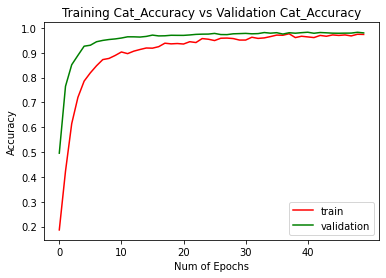

In [ ]:
# Plots for training and testing process: loss and accuracy

n_epochs = len(history.history['loss'])

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])

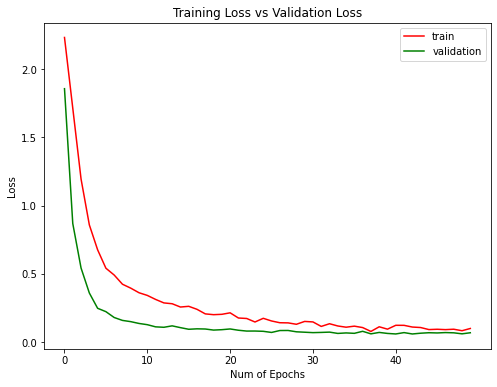

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

(1500, 28, 28)


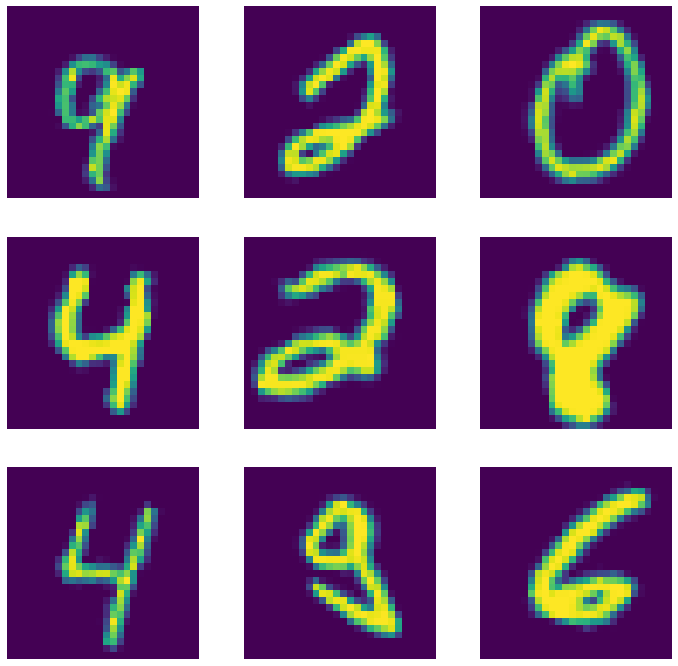

In [ ]:
print(x_train.reshape((len(x_train),img_rows, img_cols)).shape)
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].reshape((img_rows, img_cols)))
         plt.axis('off')
    plt.show()
    break

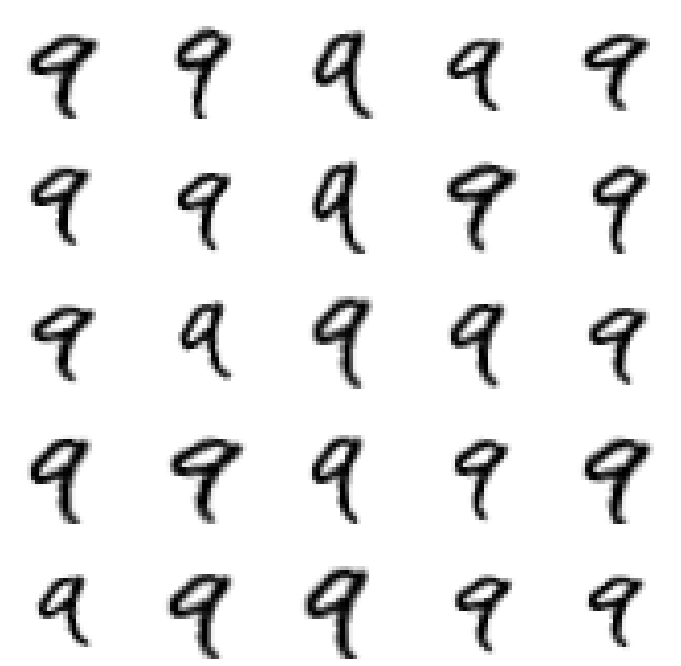

In [ ]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[4:6], y_train[4:6], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].reshape((img_rows, img_cols)), cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
         break

plt.show()

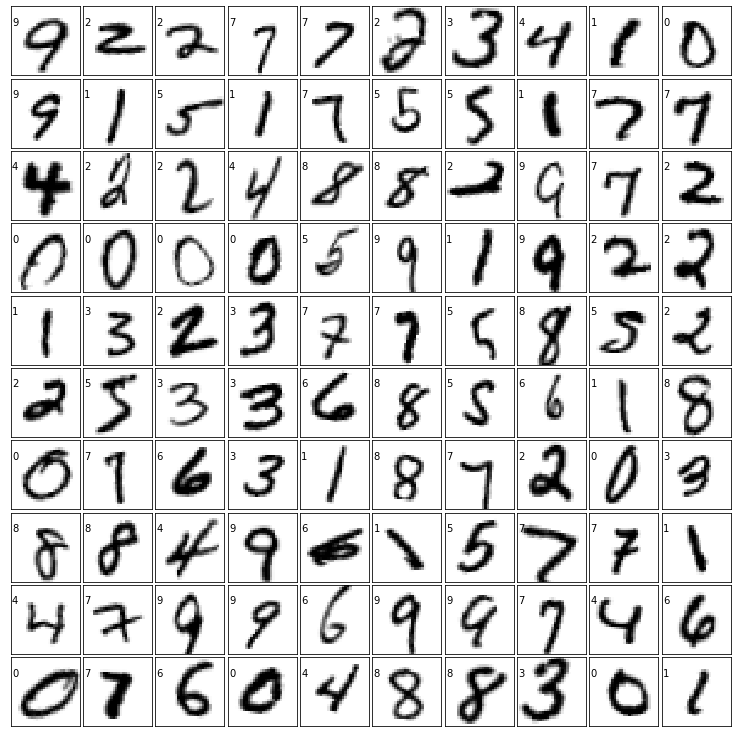

In [ ]:
#visualize the digits
fig = plt.figure(figsize=(10, 10)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# generate augmented plot
X_train, Y_train = datagen.flow(x_train,y_train, batch_size=100).next()
for i in range(100):
  ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
  # label the image with the target value
  ax.text(0, 7, str(np.argmax(Y_train[i])))

In [ ]:
# evaluate loaded model
scores_train = model.evaluate(x_train, y_train, verbose=0)
scores_test  = model.evaluate(x_test,  y_test,  verbose=0)

print("Accuracy Train: %.2f%% , Test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

Accuracy Train: 99.67% , Test: 98.02% 


In [ ]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)



#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

313/313 - 8s
[[ 972    0    3    0    0    0    3    1    1    0]
 [   0 1125    2    2    0    2    1    3    0    0]
 [   1    0 1022    0    0    0    1    8    0    0]
 [   0    0    3  987    0    9    0   10    0    1]
 [   0    1    2    0  948    0    5    1    0   25]
 [   1    1    0    3    0  884    1    1    0    1]
 [   7    3    0    0    1    2  945    0    0    0]
 [   0    2   11    1    0    0    0 1013    0    1]
 [   6    0    9    1    2    2    2    4  931   17]
 [   3    1    0    1    5   12    1    9    2  975]]


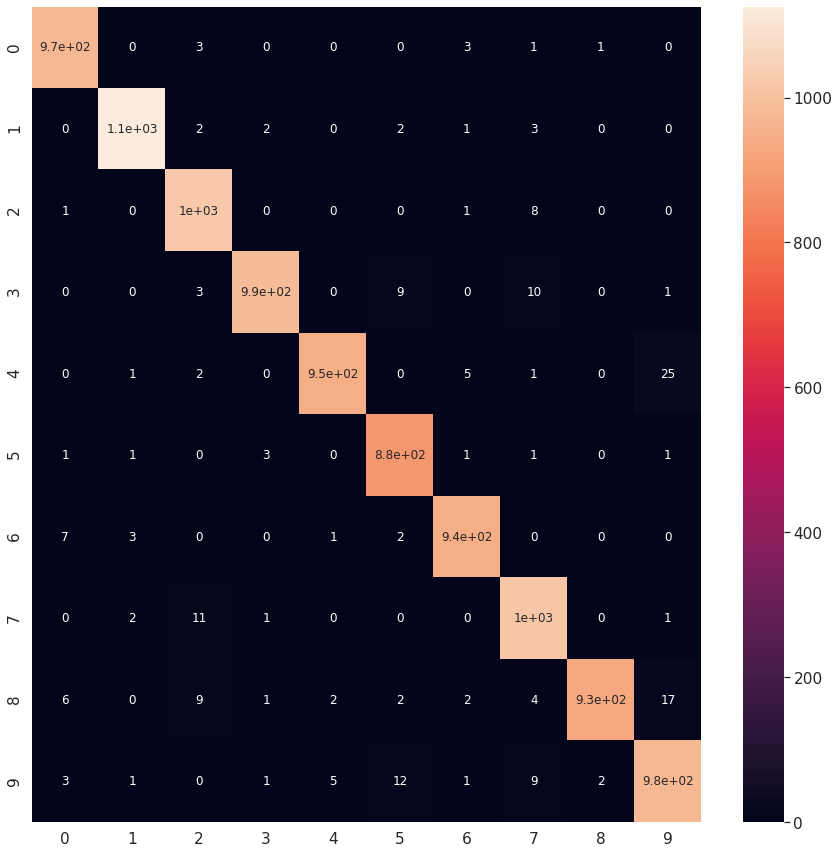

In [ ]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
#                     range(num_classes),
#                  range(num_classes))
#plt.figure(figsize = (10,7))
plt.figure(2,figsize = (15,15) )
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

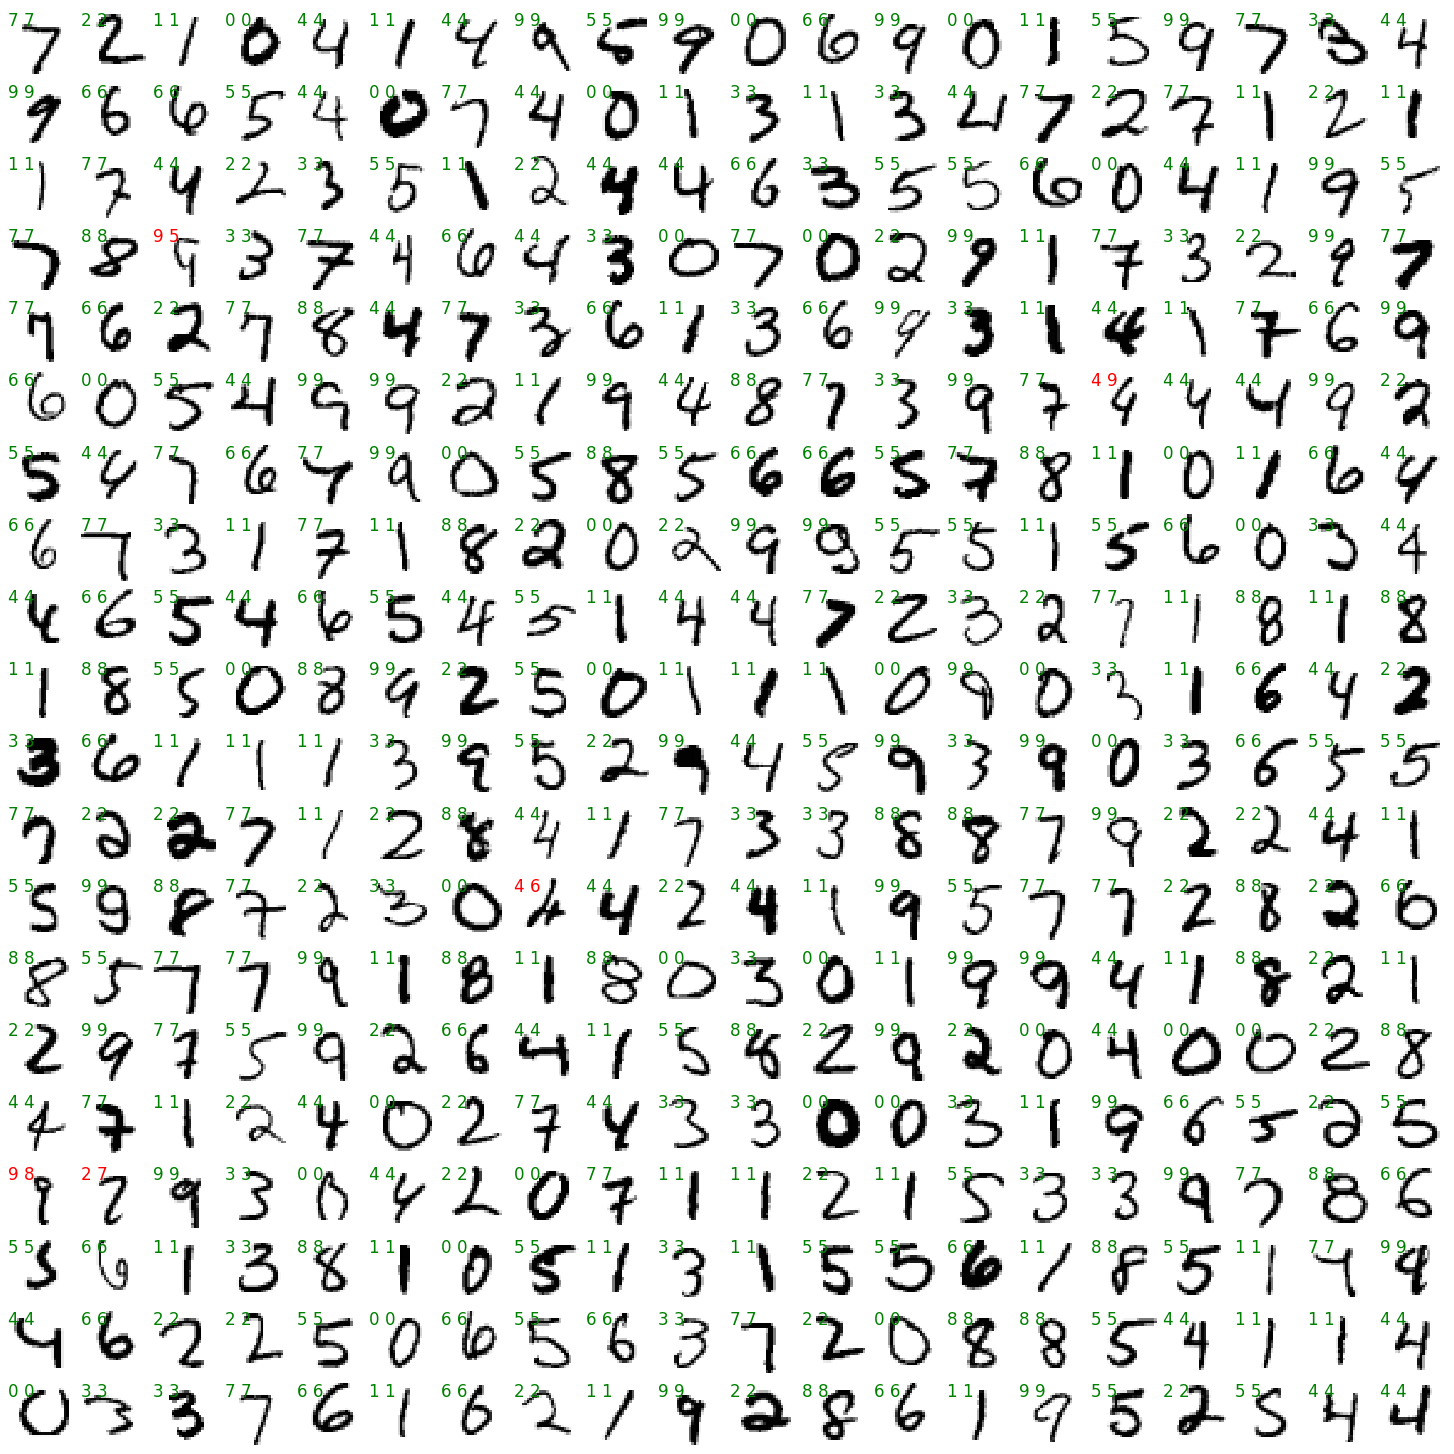

In [ ]:
# use the model to predict the labels of the test data
predicted = model.predict(x_test)
expected = y_test0



# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if np.argmax(predicted[i]) == expected[i]:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='green')
    else:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='red')

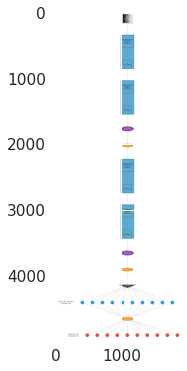

In [ ]:
# Creates the graph.png file

! pip3 install keras-visualizer
from keras_visualizer import visualizer  

#create the graph.png image
visualizer(model=model, view=True, format='png', filename='graph')

#show the graph
import matplotlib.image as mpimg
img = mpimg.imread('graph.png')
imgplot = plt.imshow(img,)
plt.show()